In [ ]:
!unzip /content/python.zip

In [ ]:
!unzip /content/Tennis_Linux_NoVis.zip

In [5]:
%cd /content

/content


In [ ]:
!python setup.py install

**1. Start the Environment**

In [4]:
import time
import copy
import random
from collections import namedtuple, deque

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from unityagents import UnityEnvironment
from tqdm import tqdm
from fastprogress import progress_bar, master_bar


In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
env = UnityEnvironment(file_name='/content/Tennis_Linux_NoVis/Tennis.x86_64')
brain_name = env.brain_names[0]
brain = env.brains[brain_name]


BUFFER_SIZE  = int(1e5)        # replay buffer size
BATCH_SIZE   = 128             # minibatch size
GAMMA        = 0.99            # discount factor
TAU          = 1e-3            # for soft update of target parameters
LR_ACTOR     = 2e-4            # learning rate of the actor
LR_CRITIC    = 2e-4            # learning rate of the critic
WEIGHT_DECAY = 0               # L2 weight decay


**2. Examine the State and Action Spaces**

In [8]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space
state = env_info.vector_observations
state_size = state.shape[1]

print('There are {} agents. Each observes a state with length: {}'
      .format(state.shape[0], state_size))
print('The observation for the first agent looks like:\n', state[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The observation for the first agent looks like:
 [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


**3.Defining the Agent, NN and train function**

In [9]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.bn1 = nn.BatchNorm1d(fc1_units)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        if state.dim() == 1:
            state = torch.unsqueeze(state,0)
        x = F.relu(self.fc1(state))
        x = self.bn1(x)
        x = F.relu(self.fc2(x))
        return F.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=128, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.bn1 = nn.BatchNorm1d(fcs1_units)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        if state.dim() == 1:
            state = torch.unsqueeze(state,0)
        xs = F.relu(self.fcs1(state))
        xs = self.bn1(xs)
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, random_seed=42):
        """Initialize an Agent object.

        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Make sure the Target Network has the same weight values as the Local Network # PJD
        for target, local in zip(self.actor_target.parameters(), self.actor_local.parameters()):
            target.data.copy_(local.data)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Make sure the Target Network has the same weight values as the Local Network  # PJD
        for target, local in zip(self.critic_target.parameters(), self.critic_local.parameters()):
            target.data.copy_(local.data)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)

    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.memory.add(state, action, reward, next_state, done)

        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.1):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [10]:
def ddpg_tennis(n_episodes=1500, max_t=1000, train_mode=True, target_score=0.5):
    scores_deque = deque(maxlen=100)
    scores_all = []
    agents_scores = np.zeros((n_episodes, 2))
    mean_avg_scores = []
    agents_scores = np.zeros((n_episodes, 2))  # To store scores for both agents
    achieved = False

    mb = master_bar(range(1, n_episodes+1))
    for i_episode in mb:
        env_info = env.reset(train_mode)[brain_name]
        states = env_info.vector_observations
        agent0.reset()
        agent1.reset()
        scores = np.zeros(num_agents)
        for t in progress_bar(range(max_t), parent=mb):
            action0 = agent0.act(states[0], add_noise=True)
            action1 = agent0.act(states[1], add_noise=True)
            env_info = env.step([action0, action1])[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            agent0.step(states[0], action0, rewards[0], next_states[0], dones[0])
            agent1.step(states[1], action1, rewards[1], next_states[1], dones[1])
            states = next_states
            scores += rewards
            if np.any(dones):
                break
        scores_deque.append(np.max(scores))
        scores_all.append(np.max(scores))
        #agents_scores.append(np.array(scores))

        mean_avg_scores.append(np.mean(scores_deque))
        agents_scores[i_episode-1] = scores  # Store scores for both agents

        if i_episode % 100 == 0:
            print('\rEpisode {}\tScore {:.2f}\tAverage Score {:.2f}'.format(i_episode, np.max(scores), np.mean(scores_deque)))

        if mean_avg_scores[-1] >= target_score and not achieved:
            print('Score of', mean_avg_scores[-1], 'achieved in', i_episode, 'episodes')
            torch.save(agent0.actor_local.state_dict(), 'checkpoint_actor0.pth')
            torch.save(agent0.critic_local.state_dict(), 'checkpoint_critic0.pth')
            torch.save(agent1.actor_local.state_dict(), 'checkpoint_actor1.pth')
            torch.save(agent1.critic_local.state_dict(), 'checkpoint_critic1.pth')
            achieved = True


    return scores_all,agents_scores, mean_avg_scores

In [11]:
agent0 = Agent(state_size, action_size)
agent1 = Agent(state_size, action_size)

In [12]:
scores_all,agents_scores, avg_scores = ddpg_tennis()

Episode 100	Score 0.00	Average Score 0.00
Episode 200	Score 0.00	Average Score 0.00
Episode 300	Score 0.00	Average Score 0.00
Episode 400	Score 0.00	Average Score 0.02
Episode 500	Score 0.00	Average Score 0.00
Episode 600	Score 0.00	Average Score 0.00
Episode 700	Score 0.10	Average Score 0.01
Episode 800	Score 0.10	Average Score 0.05
Episode 900	Score 0.10	Average Score 0.07
Episode 1000	Score 0.10	Average Score 0.07
Episode 1100	Score 0.20	Average Score 0.09
Episode 1200	Score 0.09	Average Score 0.11
Score of 0.5148000077158212 achieved in 1254 episodes


Episode 1300	Score 0.10	Average Score 1.50
Episode 1400	Score 0.00	Average Score 1.70
Episode 1500	Score 0.00	Average Score 1.13


**4. Plotting the score achieved in these 1500 episodes**

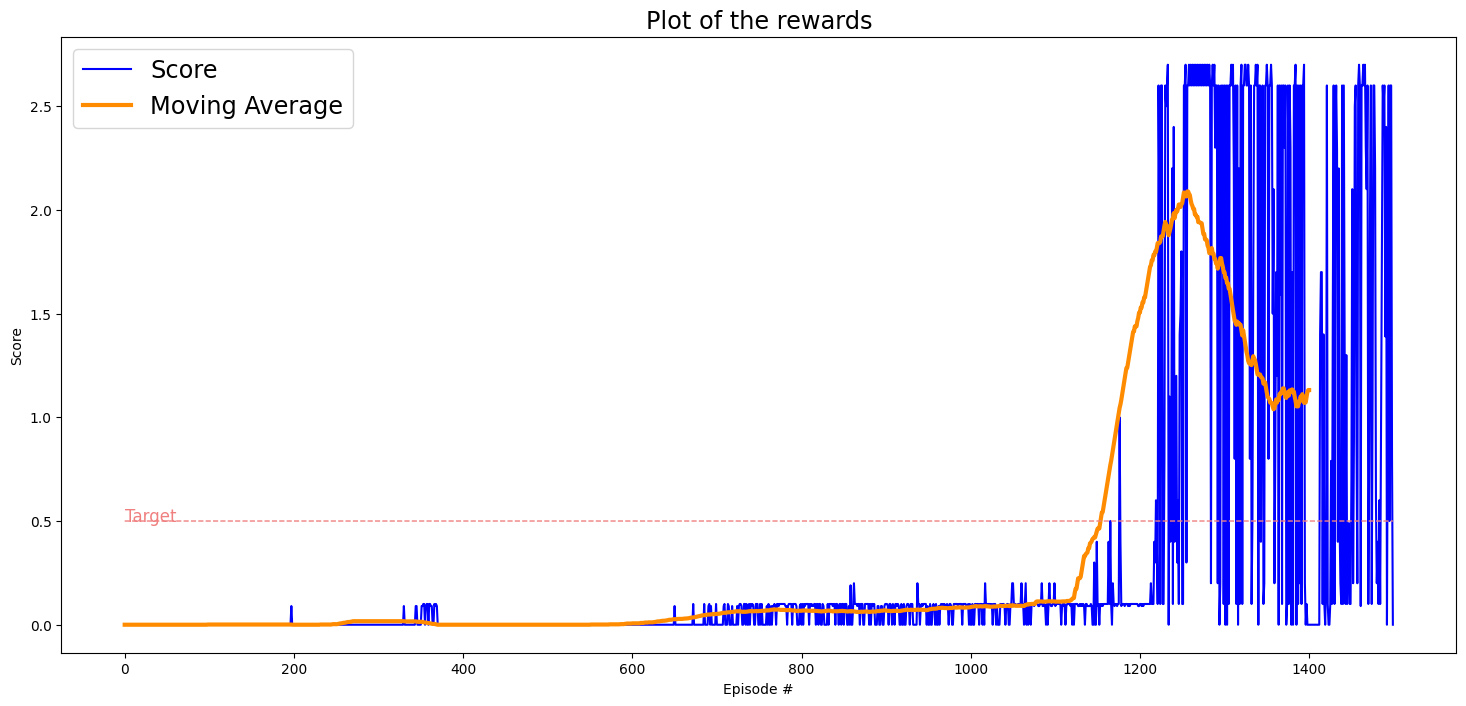

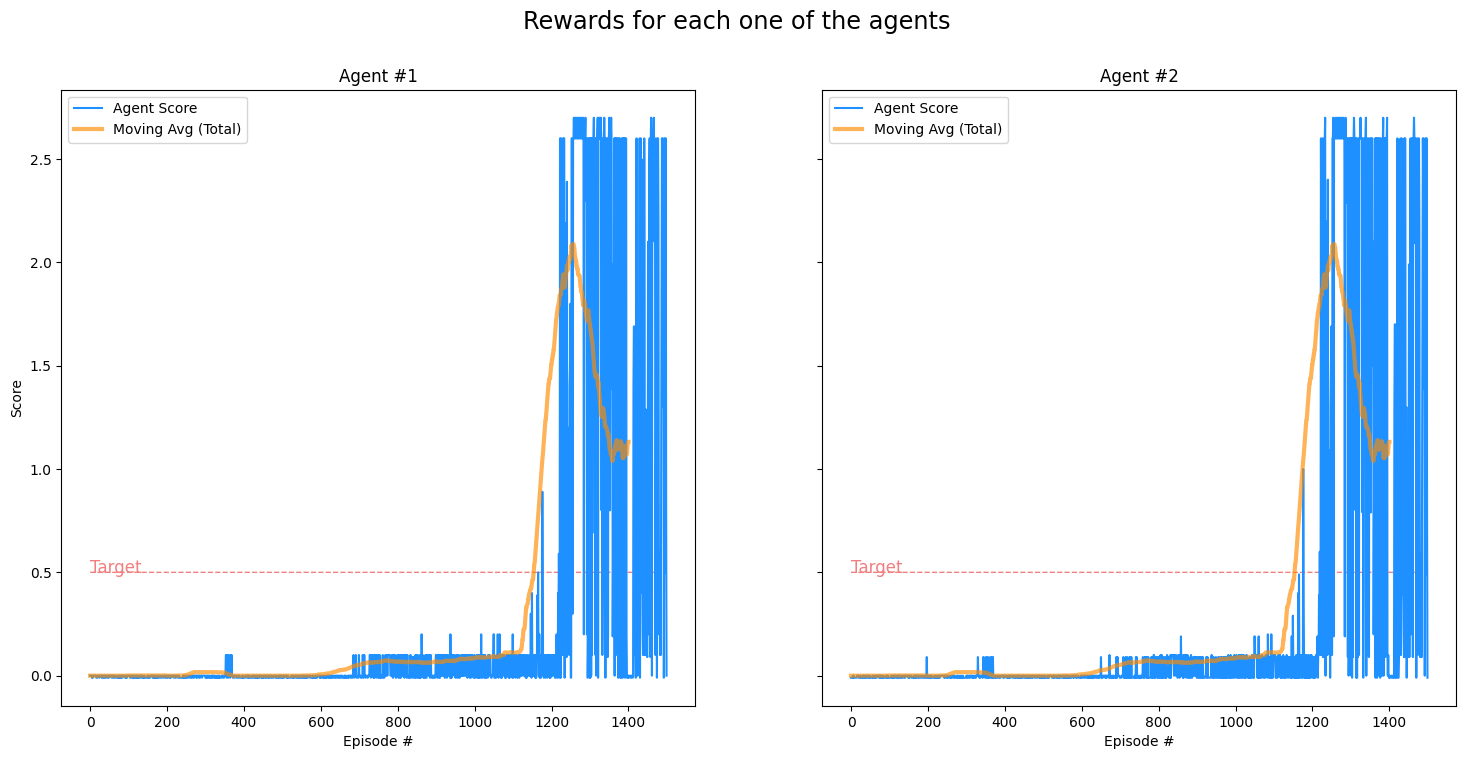

In [13]:
target_score=0.5
moving_avg = np.convolve(scores_all, np.ones(100)/100, mode='valid')
target = [target_score] * len(scores_all)

# Plotting the total rewards
fig = plt.figure(figsize=(18, 8))
ax = fig.add_subplot(111)
ax.set_title('Plot of the rewards', fontsize='xx-large')
ax.plot(scores_all, label='Score', color='Blue')
ax.plot(moving_avg, label='Moving Average', color='DarkOrange', linewidth=3)
ax.plot(target, linestyle='--', color='LightCoral', linewidth=1)
ax.text(0, target_score, 'Target', color='LightCoral', fontsize='large')
ax.set_ylabel('Score')
ax.set_xlabel('Episode #')
ax.legend(fontsize='xx-large')
plt.show()

    # Plotting rewards for each agent
fig, axs = plt.subplots(1, 2, figsize=(18, 8), sharex=True, sharey=True)
fig.suptitle('Rewards for each one of the agents', fontsize='xx-large')
axs = axs.flatten()
for idx, (ax, s) in enumerate(zip(axs, np.transpose(agents_scores))):
        ax.plot(s, label='Agent Score', color='DodgerBlue', zorder=1)
        ax.plot(moving_avg, label='Moving Avg (Total)', color='DarkOrange', linewidth=3, alpha=0.655, zorder=2)
        ax.plot(target, linestyle='--', color='LightCoral', linewidth=1, zorder=0)
        ax.text(0, target_score, 'Target', color='LightCoral', fontsize='large')
        ax.set_title('Agent #%d' % (idx+1))
        ax.set_ylabel('Score')
        ax.set_xlabel('Episode #')
        ax.label_outer()
        ax.legend(fontsize='medium')

plt.show()
